In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=50
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_win2_load_all.d2v'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win2_load_all.d2v


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.9926796 , -0.95616704, -0.41943806,  1.05640149, -0.17750672,
       -0.22473556, -1.14849627, -1.04512095,  0.72278821, -0.26906219,
       -0.12173071,  0.27951074,  0.85554093,  1.4066658 , -0.66658169,
       -3.5733881 ,  0.61995304, -2.23058319, -0.13402276,  2.12668133,
       -0.35180882, -0.27377269,  0.54994392, -1.48118317, -1.4935751 ,
       -1.68159318,  0.34006077,  2.6541965 , -0.45972574, -0.43201742,
        0.3170231 , -1.63518965,  2.0632391 ,  1.46774471, -0.95080161,
        0.16261423,  1.81780541,  0.94335526, -0.02719352,  0.66872084,
        0.53617448,  0.2284466 ,  1.14089978, -1.53023636, -0.30838454,
        1.86624837, -0.64276832,  0.49743181, -0.53058469,  1.06889701,
        0.34412953,  0.14060664,  1.23631251,  0.41249499, -0.50394237,
        0.92049599,  0.2226413 , -0.11276353, -0.56527591,  0.82244128,
       -0.99196661, -0.42952666, -0.88652813,  0.43424979, -1.98911691,
        1.09482539, -2.45888305,  1.73302603,  2.20067   , -0.60

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 300)
(986, 300)


array([ -2.54895630e-23,   5.88010267e-23,   2.81650348e-21,
         1.04493651e-20,  -1.60715583e-20,   1.24434412e-19,
         6.60616769e-20,  -5.26539765e-20,  -3.85386446e-20,
         2.52483776e-20,   1.39661431e-20,   8.50140906e-20,
         3.79913131e-22,  -4.83528457e-23,  -4.21427623e-21,
         4.14869235e-22,  -8.26349734e-21,  -3.16981263e-21,
        -5.90581183e-21,   9.49572313e-22,  -3.37592662e-22,
         5.28774098e-22,  -2.67761091e-22,   4.69345218e-23,
        -1.12498628e-22])

In [11]:
# this is the 4 layer full-connected nerual network model
model = nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
model.summary()

C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", input_dim=300, kernel_initializer="normal")`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  model.add(Dense(256, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  model.add(Dense(80, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:33: UserWarning: Update your `De

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 164,137
Trainable params: 164,137
Non-trainable params: 0
_________________________________________________________________


begin training

Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 16s - loss: 2.1999 - acc: 0.10 - ETA: 1s - loss: 2.1646 - acc: 0.1594 - ETA: 0s - loss: 2.1112 - acc: 0.202 - ETA: 0s - loss: 2.0673 - acc: 0.217 - ETA: 0s - loss: 2.0267 - acc: 0.236 - 0s - loss: 1.9860 - acc: 0.2542 - val_loss: 1.6948 - val_acc: 0.3753
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 1.7520 - acc: 0.359 - ETA: 0s - loss: 1.7900 - acc: 0.349 - ETA: 0s - loss: 1.7780 - acc: 0.358 - ETA: 0s - loss: 1.7656 - acc: 0.365 - ETA: 0s - loss: 1.7196 - acc: 0.380 - 0s - loss: 1.7109 - acc: 0.3846 - val_loss: 1.4492 - val_acc: 0.4743
Training accuracy: 38.46% / Best validation accuracy: 47.43%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 1.5208 - acc: 0.421 - ETA: 0s - loss: 1.4792 - acc: 0.451 - ETA: 0s - loss: 1.4906 - acc: 0.468 - ETA: 0s - loss: 1.4921 - acc: 0

Training accuracy: 66.72% / Best validation accuracy: 57.45%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.8607 - acc: 0.687 - ETA: 0s - loss: 0.8889 - acc: 0.675 - ETA: 0s - loss: 0.9015 - acc: 0.666 - ETA: 0s - loss: 0.9036 - acc: 0.664 - ETA: 0s - loss: 0.9123 - acc: 0.660 - 0s - loss: 0.9095 - acc: 0.6621 - val_loss: 1.2072 - val_acc: 0.5203
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.8960 - acc: 0.640 - ETA: 0s - loss: 0.8897 - acc: 0.649 - ETA: 0s - loss: 0.8904 - acc: 0.662 - ETA: 0s - loss: 0.8831 - acc: 0.664 - ETA: 0s - loss: 0.8867 - acc: 0.668 - 0s - loss: 0.8904 - acc: 0.6686 - val_loss: 1.1849 - val_acc: 0.5691
Training accuracy: 66.86% / Best validation accuracy: 57.45%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.7319 - acc: 0.734 - ETA: 0s - loss: 0.8502 - acc: 0.681 - ETA: 0s - loss: 0.8460 - 

2951/2951 [==============================] - ETA: 0s - loss: 0.6813 - acc: 0.656 - ETA: 0s - loss: 0.8354 - acc: 0.666 - ETA: 0s - loss: 0.7640 - acc: 0.696 - ETA: 0s - loss: 0.7468 - acc: 0.703 - ETA: 0s - loss: 0.7604 - acc: 0.698 - ETA: 0s - loss: 0.7530 - acc: 0.702 - 0s - loss: 0.7518 - acc: 0.7055 - val_loss: 1.1970 - val_acc: 0.5718
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.7118 - acc: 0.750 - ETA: 0s - loss: 0.7177 - acc: 0.732 - ETA: 0s - loss: 0.7281 - acc: 0.744 - ETA: 0s - loss: 0.7320 - acc: 0.734 - ETA: 0s - loss: 0.7333 - acc: 0.733 - 0s - loss: 0.7368 - acc: 0.7323 - val_loss: 1.2021 - val_acc: 0.5691
Training accuracy: 73.23% / Best validation accuracy: 57.99%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.6412 - acc: 0.765 - ETA: 0s - loss: 0.7205 - acc: 0.712 - ETA: 0s - loss: 0.7313 - acc: 0.706 - ETA: 0s - loss: 0.7218 - acc: 0.721 - ETA: 0s - loss: 0.7277 - acc:

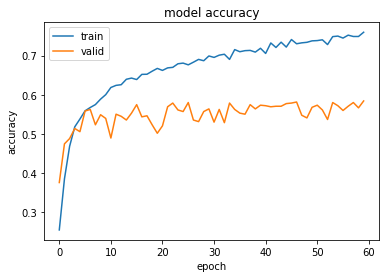

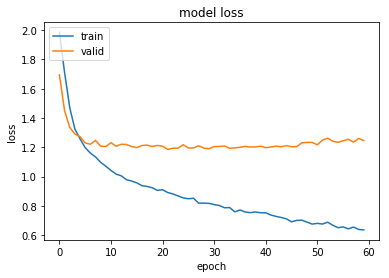

 32/986 [..............................] - ETA: 0s

In [13]:
model = train_nn_model(model, train_set, encoded_y, filename = 'try(win2)loadgene100.h5')
y_predict = model.predict_proba(test_set)

In [14]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

In [15]:
y_predict = xgbclassifier(train_set, train_y, test_set, 1, 8, 1000)

[0]	train-mlogloss:2.11698	valid-mlogloss:2.13688
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.06815	valid-mlogloss:1.41032
[50]	train-mlogloss:0.628532	valid-mlogloss:1.14877
[75]	train-mlogloss:0.385488	valid-mlogloss:1.03278
[100]	train-mlogloss:0.25754	valid-mlogloss:0.975977
[125]	train-mlogloss:0.179182	valid-mlogloss:0.949277
[150]	train-mlogloss:0.128167	valid-mlogloss:0.939165
[175]	train-mlogloss:0.093374	valid-mlogloss:0.93919
[200]	train-mlogloss:0.068502	valid-mlogloss:0.943457
[225]	train-mlogloss:0.052048	valid-mlogloss:0.94757
[250]	train-mlogloss:0.041119	valid-mlogloss:0.952544
Stopping. Best iteration:
[168]	train-mlogloss:0.101939	valid-mlogloss:0.938151

final validation loss:
0.938151179632
final validation accuracy:
0.685714285714


In [16]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2loadgene100.csv")